In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

# Data Cleaning

## Applications Table

In [ ]:
app_train = pd.read_csv("../../Project/Home_credits_loan/all/application_train.csv")

#Values "XNA" (not availables) will be replaced by NaN values
app_train.replace("XNA", np.nan, inplace=True)

In [ ]:
#See if there are any duplicated rows
duplicate_rows = app_train[app_train.duplicated()]
len(duplicate_rows)

0

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [ ]:
variables_type = pd.DataFrame(app_train.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in app_train:
    if ((list(app_train[i].unique()) == [0,1]) or (list(app_train[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "TARGET"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Categorical variables (binary): ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUM

#### Analyzing missing values

Building a model on variables that have higher than 50% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values by the median

In [ ]:
#List the variables with missing values higher or equal to 50% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 50% to preprocess them later on
miss_lower50 = []
miss_higher50 = []

for i in app_train:
    pct_missing = (app_train[i].isna().sum()/len(app_train[i]))*100
    if pct_missing > 0 and pct_missing < 50:
        miss_lower50.append(i)
    if pct_missing >= 50:
        miss_higher50.append(i)

In [ ]:
#Exclude the variables with missing values higher or equal to 50%
cat_variables = [i for i in cat_variables if i not in miss_higher50]
cat_binary_variables = [i for i in cat_binary_variables if i not in miss_higher50]
num_variables = [i for i in num_variables if i not in miss_higher50]

#### Cleaning all remaining variables

##### Categorical variables

In [ ]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, app_train[i].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']
CODE_GENDER ['M' 'F' nan]
FLAG_OWN_CAR ['N' 'Y']
FLAG_OWN_REALTY ['Y' 'N']
NAME_TYPE_SUITE ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 

Findings:
- FLAG_OWN_CAR, FLAG_OWN_REALTY AND EMERGENCYSTATE_MODE are already binary variables codified in a different way (Yes/No)

In [ ]:
#Change binary variables from Yes/No to 1/0
app_train["FLAG_OWN_CAR"] = app_train["FLAG_OWN_CAR"].apply(lambda x: 0 if x == 'N' else 1)
app_train["FLAG_OWN_REALTY"] = app_train["FLAG_OWN_REALTY"].apply(lambda x: 0 if x == 'N' else 1)
app_train["EMERGENCYSTATE_MODE"] = app_train["EMERGENCYSTATE_MODE"].apply(lambda x: 0 if x == 'No' else (1 if x == 'Yes' else x))

#Exclude them from cat_variables and include them in cat_binary_variables (useful for the final pipeline)
cat_variables = [i for i in cat_variables if i not in ["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"]]
cat_binary_variables.extend(["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"])

##### Numerical variables

In [ ]:
#Using describe method for numerical variables to get summary statistics and explore the data
app_train[num_variables].describe()

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,-16036.995067,63815.045904,-2994.202373,2.052463,2.031521,12.063419,1.687979e+05,5.990260e+05,27108.573909,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,4363.988632,141275.766519,1509.450419,0.509034,0.502737,3.265832,2.371231e+05,4.024908e+05,14493.737315,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,-25229.000000,-17912.000000,-7197.000000,1.000000,1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-19682.000000,-2760.000000,-4299.000000,2.000000,2.000000,10.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-15750.000000,-1213.000000,-3254.000000,2.000000,2.000000,12.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,-12413.000000,-289.000000,-1720.000000,2.000000,2.000000,14.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,-7489.000000,365243.000000,0.000000,3.000000,3.000000,23.000000,1.170000e+08,4.050000e+06,258025.500000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Findings:
- "DAYS(...)" variables are counter-intuitively negative
- "REGION_RATING_CLIENT(...)" variables should be consider categorical since they only have values 1, 2 and 3
- DAYS_EMPLOYED mean is 63815 (equivalent to around 174.8 years of experience), so there should be outliers (wrongly inserted values) we need to look deeper at

In [ ]:
#Exclude them "REGION_RATING_CLIENT(...)" variables from num_variables and include them in cat_variables (useful for the final pipeline)
num_variables = [i for i in num_variables if i not in ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]
cat_variables.extend(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])

<AxesSubplot:>

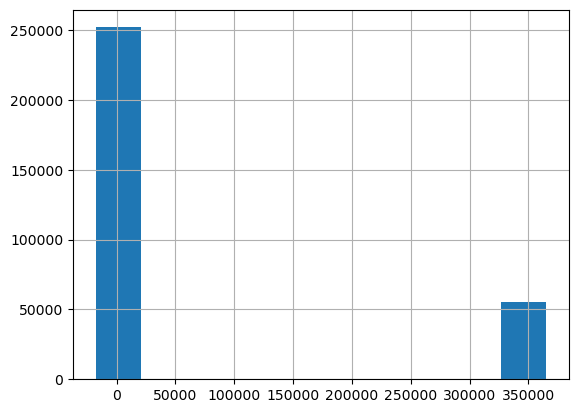

In [ ]:
#Plot the DAYS_EMPLOYED variable to see why mean is equivalent to 174.8 years of experience (outliers that don't make sense)
app_train["DAYS_EMPLOYED"].hist()

In [ ]:
#See how many wrongly inserted values there is and if there is a specific value that is causing it
print(app_train[app_train["DAYS_EMPLOYED"] > 325000][["DAYS_EMPLOYED"]].value_counts())

#After finding that there is 55374 with valu 365243 days employed, we set them to NaN (to be cleaned in the preprocessing pipeline)
app_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

DAYS_EMPLOYED
365243           55374
dtype: int64


In [ ]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in app_train.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

#### Transformation Pipeline

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, app_train, y=None):
        return self
    def transform(self, bank):
        return app_train[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names

In [ ]:
def negative_to_positive(columns):
    for i in columns:
        app_train[i] = abs(app_train[i])

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', negative_to_positive(day_variables)),
        ('selector', DataFrameSelector(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('selector', DataFrameSelector(cat_binary_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

In [ ]:
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables),
        ("cat_binary_pipeline", cat_binary_pipeline, cat_binary_variables)
])

In [ ]:
preprocess_pipeline.fit(app_train)

preprocessed_app_train = preprocess_pipeline.transform(app_train)

c:\Users\HP\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [ ]:
num_feature_names = preprocess_pipeline.named_transformers_['num_pipeline'].named_steps['selector'].get_feature_names()
day_feature_names = preprocess_pipeline.named_transformers_['days_pipeline'].named_steps['selector'].get_feature_names()
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_feature_names + day_feature_names + cat_feature_names + cat_binary_variables

In [ ]:
transformed_app_train_df = pd.DataFrame(preprocessed_app_train, columns=feature_names)
transformed_app_train_df = pd.concat([app_train[["SK_ID_CURR", "TARGET"]],transformed_app_train_df], axis=1)
transformed_app_train_df

,SK_ID_CURR,TARGET,CNT_CHILDREN,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,100002,1,-0.577538,-0.631821,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,-0.577538,-0.325620,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.167638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,-0.577538,-0.938022,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,100006,0,-0.577538,1.511587,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.167638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0,-0.577538,-0.325620,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,-0.577538,0.899185,-0.047646,-0.855489,0.031015,-0.848433,0.845396,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0,-0.577538,-1.244224,-0.408219,-0.818594,-1.042333,-0.848433,0.310593,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307508,456253,0,-0.577538,-0.938022,-0.066623,0.195379,0.198056,0.126415,-1.147120,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307509,456254,1,-0.577538,-0.938022,0.009287,-0.568757,-0.476318,-0.592535,-1.124635,-0.167638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Credit card balance

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

CUSTOMER RISK PROFILE

- Number of Loans per Customer
- Rate at which Loan is paid back by customer - No of instalments per customer per loan
- How much did the Customer load a Credit line?
- How many times did the Customer miss the minimum payment?
- What is the average number of days did Customer go past due date?
- What fraction of minimum payments were missed?

CUSTOMER BEHAVIOUR PATTERNS

- Cash withdrawals VS Overall Spending ratio
- Average number of drawings per customer - Total Drawings / Number of Drawings

In [ ]:
# Load data
credit_card_balance = pd.read_csv('credit_card_balance.csv', sep=',')

credit_card_balance.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,...,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,...,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


In [ ]:
# Identify duplicate rows
duplicate_rows = credit_card_balance[credit_card_balance.duplicated()]
len(duplicate_rows)

0

### Feature selection

In [ ]:
# Feature selection
credit_card_balance.loc[0:10, ["SK_ID_PREV", "SK_ID_CURR", "AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT"]]

,SK_ID_PREV,SK_ID_CURR,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT
0,2562384,378907,1800.000,1800.000
1,2582071,363914,2250.000,2250.000
2,1740877,371185,2250.000,2250.000
3,1389973,337855,11925.000,11925.000
4,1891521,126868,27000.000,27000.000
5,2646502,380010,3825.000,3825.000
6,1079071,171320,15750.000,15750.000
7,2095912,118650,264.690,0.000
8,2181852,367360,4093.515,4093.515
9,1235299,203885,45000.000,45000.000


In [ ]:
credit_card_balance.loc[credit_card_balance["AMT_PAYMENT_CURRENT"] < credit_card_balance["AMT_PAYMENT_TOTAL_CURRENT"],
                        :].loc[:, ["AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT"]]

,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT


AMT_PAYMENT_CURRENT is never lower than AMT_PAYMENT_TOTAL_CURRENT (it is always higher or equal, or they are both null), which means that AMT_PAYMENT_CURRENT contains the value in AMT_PAYMENT_TOTAL_CURRENT. Therefore, we can drop that column.

In [ ]:
credit_card_balance.loc[credit_card_balance["AMT_DRAWINGS_CURRENT"] < credit_card_balance["AMT_DRAWINGS_ATM_CURRENT"], :].loc[:, ["AMT_DRAWINGS_CURRENT",
                                                                                                                                  "AMT_DRAWINGS_ATM_CURRENT"]]

,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_ATM_CURRENT
438776,-1687.50,0.0
747302,-519.57,0.0
3284667,-6211.62,0.0


Same thing for AMT_DRAWINGS_CURRENT and AMT_DRAWINGS_ATM_CURRENT. Even though the amount of drawings in the ATM may be zero, the amount of drawings in total can be negative - when the amount of money drawing during a month by a client is lower than zero, it means that the client has made a payment to the bank that is greater than the outstanding balance on their credit card.

Therefore, we can drop AMT_DRAWINGS_ATM_CURRENT, because AMT_DRAWINGS_CURRENT contains all the information. Same thing applies to AMT_DRAWINGS_POS_CURRENT. 

In [ ]:
credit_card_balance.loc[0:10, ["AMT_DRAWINGS_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT"]]

,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT
0,877.500,0.0
1,2250.000,0.0
2,0.000,0.0
3,2250.000,0.0
4,11547.000,0.0
5,0.000,0.0
6,67500.000,0.0
7,45000.000,0.0
8,289339.425,0.0
9,111026.700,0.0


In [ ]:
credit_card_balance.loc[credit_card_balance["AMT_DRAWINGS_CURRENT"] < credit_card_balance["AMT_DRAWINGS_OTHER_CURRENT"], :].loc[:, ["AMT_DRAWINGS_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT"]]

,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT
438776,-1687.50,0.0
747302,-519.57,0.0
3284667,-6211.62,0.0


We can also drop this column.

Regarding AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE and AMT_TOTAL_RECEIVABLE, since AMT_TOTAL_RECEIVABLE is the total amount receivable on the previous credit, that contains the number we need and we can drop the other two columns.

Considering the columns we decided to drop, regarding the 4 columns with the number of drawings in the month in matter, it only makes sense to keep CNT_DRAWINGS_CURRENT, because that's what we can connect to the information that wasn't dropped. Also, that column contains total number of drawings, while the other 3 contained very specific drawings.

In [ ]:
# Drop the columns

credit_card_balance.drop(['AMT_PAYMENT_TOTAL_CURRENT', 'AMT_DRAWINGS_ATM_CURRENT',
                          'AMT_DRAWINGS_POS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
                          "AMT_RECEIVABLE_PRINCIPAL", "AMT_RECIVABLE",
                          "CNT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT",
                          "CNT_DRAWINGS_POS_CURRENT", "AMT_INST_MIN_REGULARITY"],
                         axis=1, inplace=True)

In [ ]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,877.5,1800.00,0.000,1,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.00,64875.555,1,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,2250.00,31460.085,0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,11925.00,233048.970,1,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,11547.0,27000.00,453919.455,1,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,0.0,NaN,0.000,0,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,1879.11,0.000,0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,375750.00,273093.975,2,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,0.0,NaN,0.000,0,0.0,Active,0,0


### Dealing with missing values

In [ ]:
# Deal with missing values

n_null_dict = {}

for column in credit_card_balance.columns:
    null_sum = credit_card_balance.isnull()[column].sum()
    n_null_dict[column] = null_sum

n_null = pd.DataFrame(n_null_dict, index = ["Number of missing values"])

In [ ]:
n_null

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
Number of missing values,0,0,0,0,0,0,767988,0,0,305236,0,0,0


We could replace the missing values using a statistical method such as mean, median, or mode. However, each client is different and has different ATM movements, so imputing with a single value may not be appropriate.

Therefore, the approach we will take is to impute the missing values based on similar clients: group clients by some relevant characteristics.

In [ ]:
# Missing values in AMT_PAYMENT_CURRENT

# Check variable more correlated with AMT_PAYMENT_CURRENT

corr_payment_current = credit_card_balance.corr().abs()
pearson_payment_current = corr_payment_current["AMT_PAYMENT_CURRENT"]
pearson_payment_current.sort_values(axis = 0, ascending = False)

AMT_PAYMENT_CURRENT          1.000000
AMT_DRAWINGS_CURRENT         0.337343
AMT_CREDIT_LIMIT_ACTUAL      0.308294
CNT_DRAWINGS_CURRENT         0.223483
AMT_BALANCE                  0.143934
AMT_TOTAL_RECEIVABLE         0.142371
CNT_INSTALMENT_MATURE_CUM    0.079266
MONTHS_BALANCE               0.076355
SK_DPD                       0.030222
SK_DPD_DEF                   0.004340
SK_ID_PREV                   0.003472
SK_ID_CURR                   0.000127
Name: AMT_PAYMENT_CURRENT, dtype: float64

AMT_DRAWINGS_CURRENT seems to be the variable with the highest correlation with AMT_PAYMENT_CURRENT. Let's group clients based on that.

In [ ]:
# Create new column with quantile bin for AMT_DRAWINGS_CURRENT

credit_card_balance['drawings_quantile'] = pd.qcut(credit_card_balance['AMT_DRAWINGS_CURRENT'],
                                                   2, labels=False, duplicates='drop')

# Compute median for each quantile 

quantile_medians = credit_card_balance.groupby('drawings_quantile')['AMT_DRAWINGS_CURRENT'].median()

quantile_medians

# Replace missing values in AMT_PAYMENT_CURRENT with the median for the corresponding quantile of AMT_DRAWINGS_CURRENT

for quantile in range(2):
    
    mask = (credit_card_balance['drawings_quantile'] == quantile) & credit_card_balance['AMT_PAYMENT_CURRENT'].isna()
    credit_card_balance.loc[mask, 'AMT_PAYMENT_CURRENT'] = quantile_medians[quantile]

credit_card_balance.drop("drawings_quantile", axis=1, inplace=True)

In [ ]:
# Missing values in CNT_INSTALMENT_MATURE_CUM

# Check variable more correlated with CNT_INSTALMENT_MATURE_CUM

corr_instalment_mature = credit_card_balance.corr().abs()
pearson_instalment_mature = corr_instalment_mature["CNT_INSTALMENT_MATURE_CUM"]
pearson_instalment_mature.sort_values(axis = 0, ascending = False)

CNT_INSTALMENT_MATURE_CUM    1.000000
AMT_CREDIT_LIMIT_ACTUAL      0.157269
CNT_DRAWINGS_CURRENT         0.099186
AMT_DRAWINGS_CURRENT         0.093491
SK_DPD                       0.059654
AMT_PAYMENT_CURRENT          0.028843
MONTHS_BALANCE               0.008620
SK_ID_PREV                   0.007219
AMT_TOTAL_RECEIVABLE         0.005959
AMT_BALANCE                  0.005009
SK_DPD_DEF                   0.002156
SK_ID_CURR                   0.000581
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64

In [ ]:
# Create new column with quantile bin for AMT_CREDIT_LIMIT_ACTUAL

credit_card_balance['drawings_quantile'] = pd.qcut(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'],
                                                   4, labels=False, duplicates='drop')

# Compute median for each quantile 

quantile_medians = credit_card_balance.groupby('drawings_quantile')['AMT_CREDIT_LIMIT_ACTUAL'].median()

quantile_medians

# Replace missing values in AMT_PAYMENT_CURRENT with the median for the corresponding quantile of AMT_DRAWINGS_CURRENT

for quantile in range(2):
    
    mask = (credit_card_balance['drawings_quantile'] == quantile) & credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].isna()
    credit_card_balance.loc[mask, 'CNT_INSTALMENT_MATURE_CUM'] = quantile_medians[quantile]

credit_card_balance.drop("drawings_quantile", axis=1, inplace=True)

### Final pipeline to transform data and get new dataframe:

In [ ]:
# Pipeline to transform numerical and categorical features

numerical_features = [col for col in credit_card_balance.columns if col != 'NAME_CONTRACT_STATUS' and col != 'SK_ID_PREV' and col != 'SK_ID_CURR']

categorical_features = ["NAME_CONTRACT_STATUS"]

# Define column transformer to apply scaling and one-hot encoding

preprocessor = make_column_transformer(
    (MinMaxScaler(), numerical_features),
    (OneHotEncoder(), categorical_features)
)

# Define the pipeline to apply the column transformer

pipeline = make_pipeline(preprocessor)

# Fit the pipeline to the original dataset 

pipeline.fit(credit_card_balance)

# Get the transformed numerical feature names

numerical_feature_names = numerical_features

# Get the transformed categorical feature names

categorical_feature_names = pipeline.named_steps['columntransformer'].transformers_[1][1].get_feature_names(categorical_features)

# Combine the feature names

feature_names = numerical_feature_names + categorical_feature_names.tolist()

# Select the columns to keep from the original dataframe

id_columns = ['SK_ID_PREV', 'SK_ID_CURR']

# Create a new dataframe with the transformed features

new_credit_card_balance = pd.DataFrame(pipeline.transform(credit_card_balance), columns=feature_names)

# Concatenate the transformed features dataframe with the original id columns

credit_card_balance = pd.concat([credit_card_balance[id_columns], new_credit_card_balance], axis=1)

/Users/patriciafonseca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Final dataset:

In [ ]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed
0,2562384,378907,0.947368,0.218211,0.100000,0.003091,0.000420,0.219614,0.006061,0.000389,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2582071,363914,1.000000,0.251395,0.033333,0.003690,0.000525,0.253516,0.006061,0.000767,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1740877,371185,0.936842,0.234699,0.333333,0.002709,0.000525,0.236054,0.000000,0.000333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1389973,337855,0.968421,0.341002,0.166667,0.003690,0.002780,0.341400,0.006061,0.000111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1891521,126868,1.000000,0.453842,0.333333,0.007744,0.006295,0.456822,0.006061,0.001122,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,0.915789,0.218181,0.033333,0.002709,0.000000,0.219614,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3840308,1714892,347207,0.915789,0.218181,0.033333,0.002709,0.000438,0.219614,0.000000,0.000256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3840309,1302323,215757,0.915789,0.361360,0.433333,0.120442,0.087604,0.362327,0.012121,0.000200,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3840310,1624872,430337,0.905263,0.218181,0.333333,0.002709,0.000000,0.219614,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Installment payments



In [ ]:
# Load data

installment_payments = pd.read_csv('installments_payments.csv', sep=',')

installment_payments.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470


In [ ]:
# Identify duplicate rows

duplicate_rows = installment_payments[installment_payments.duplicated()]
len(duplicate_rows)

0

### Dealing with missing values

In [ ]:
n_null_dict = {}

for column in installment_payments.columns:
    null_sum = installment_payments.isnull()[column].sum()
    n_null_dict[column] = null_sum

n_null = pd.DataFrame(n_null_dict, index = ["Number of missing values"])

In [ ]:
n_null

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
Number of missing values,0,0,0,0,0,2905,0,2905


We only have missing values in the collumns:

- DAYS_ENTRY_PAYMENT, which says when was the installments of previous credit paid actually (relative to application date of current loan)
- AMT_PAYMENT, what the client actually paid on previous credit on this installment

We will interpret Null values as situations where the client hasn't paid the installment at all. Let's see some examples:

In [ ]:
installment_payments[installment_payments['DAYS_ENTRY_PAYMENT'].isnull()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3764207,1531600,103793,1.0,7,-668.0,NaN,49741.020,NaN
3764208,1947105,159974,1.0,24,-36.0,NaN,22849.515,NaN
3764209,1843773,167270,1.0,22,-20.0,NaN,48092.355,NaN
3764210,1691592,192536,1.0,5,-2561.0,NaN,7675.425,NaN
3764211,1531299,157088,0.0,11,-1847.0,NaN,67.500,NaN
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


Let's replace the null values in DAYS_ENTRY_PAYMENT with "0" so that when we calculate a new column with the delay in payment, we get the delay we have relative to application date, even though the client can take even more time to make the payment.

However, we will create a new column saying whether the client has already payed previous installment or not, to identify these cases.

For the column AMT_PAYMENT, we will replace null values with 0 (because they haven't payed yet.

**How will we analyze data**: For the cases where client has payed, check values of delay time and difference between amount of installment and amount payed. Cases where client hasn't payed yet, take only into consideration that he hasn't payed yet.

In [ ]:
installment_payments['DAYS_ENTRY_PAYMENT'] = installment_payments['DAYS_ENTRY_PAYMENT'].fillna(0)
installment_payments['AMT_PAYMENT'] = installment_payments['AMT_PAYMENT'].fillna(0)

### Feature selection and new columns

DAYS_INSTALMENT columns says when the installment of previous credit was supposed to be paid, and DAYS_ENTRY_PAYMENT says when was the installments of previous credit paid actually. We'll drop those two columns and replace them with one with the difference between both. That new column will show the delay in the installment payment.

In [ ]:
# Create new column DAYS_PAYMENT_DELAY

installment_payments['DAYS_INSTALMENT'] = installment_payments['DAYS_INSTALMENT'].abs()
installment_payments['DAYS_ENTRY_PAYMENT'] = installment_payments['DAYS_ENTRY_PAYMENT'].abs()

installment_payments['DAYS_PAYMENT_DELAY'] = - (installment_payments['DAYS_ENTRY_PAYMENT'] - installment_payments['DAYS_INSTALMENT'])

In [ ]:
# Create new column DAYS_PAYMENT_DELAY

installment_payments['DAYS_INSTALMENT'] = installment_payments['DAYS_INSTALMENT'].abs()
installment_payments['DAYS_ENTRY_PAYMENT'] = installment_payments['DAYS_ENTRY_PAYMENT'].abs()

installment_payments['AMT_MISSING_PAYMENT'] = installment_payments['AMT_INSTALMENT'] - installment_payments['AMT_PAYMENT']

In [ ]:
# Create new column INSTALLMENT_PAYED

def payed_or_not(x):
    if x == 0:
        return '0'
    else:
        return '1'

installment_payments['INSTALLMENT_PAYED'] = installment_payments['DAYS_ENTRY_PAYMENT'].apply(payed_or_not)

Since we have new columns containing all the information that matters, we can drop some of the columns we had before.

In [ ]:
installment_payments.drop(['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT',
                          'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
                          "AMT_PAYMENT"], axis=1, inplace=True)

In [ ]:
installment_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_NUMBER,DAYS_PAYMENT_DELAY,AMT_MISSING_PAYMENT,INSTALLMENT_PAYED
0,1054186,161674,6,-7.0,0.000,1
1,1330831,151639,34,-0.0,0.000,1
2,2085231,193053,1,-0.0,0.000,1
3,2452527,199697,3,-8.0,0.000,1
4,2714724,167756,2,17.0,4.455,1
...,...,...,...,...,...,...
13605396,2186857,428057,66,1624.0,67.500,0
13605397,1310347,414406,47,1539.0,67.500,0
13605398,1308766,402199,43,7.0,43737.435,0
13605399,1062206,409297,43,1986.0,67.500,0


### Final pipeline to transform data and get new dataframe:

In [ ]:
# Pipeline to transform numerical features

numerical_features = [col for col in installment_payments.columns if col != 'SK_ID_PREV' and col != 'SK_ID_CURR']

# Define column transformer to apply scaling

preprocessor = make_column_transformer(
    (MinMaxScaler(), numerical_features))

# Define the pipeline to apply the column transformer

pipeline = make_pipeline(preprocessor)

# Fit the pipeline to the original dataset 

pipeline.fit(installment_payments)

# Feature names

feature_names = numerical_features

# Select the columns to keep from the original dataframe

id_columns = ['SK_ID_PREV', 'SK_ID_CURR']

# Create a new dataframe with the transformed features

new_installment_payments = pd.DataFrame(pipeline.transform(installment_payments), columns=feature_names)

# Concatenate the transformed features dataframe with the original id columns

installment_payments = pd.concat([installment_payments[id_columns], new_installment_payments], axis=1)

In [ ]:
installment_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_NUMBER,DAYS_PAYMENT_DELAY,AMT_MISSING_PAYMENT,INSTALLMENT_PAYED
0,1054186,161674,0.018116,0.521896,0.520391,1.0
1,1330831,151639,0.119565,0.523044,0.520391,1.0
2,2085231,193053,0.000000,0.523044,0.520391,1.0
3,2452527,199697,0.007246,0.521732,0.520391,1.0
4,2714724,167756,0.003623,0.525832,0.520392,1.0
...,...,...,...,...,...,...
13605396,2186857,428057,0.235507,0.789405,0.520405,0.0
13605397,1310347,414406,0.166667,0.775463,0.520405,0.0
13605398,1308766,402199,0.152174,0.524192,0.529043,0.0
13605399,1062206,409297,0.152174,0.848778,0.520405,0.0
